<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/build_your_own_semantic_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Your Own Semantic Search Engine

## Install library

In [ ]:
!pip install -q numpy pandas transformers sentence_transformers datasets sentencepiece faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 965.1 kB/s eta 0:0

## Import library

In [ ]:
from tqdm import tqdm
from datasets import load_dataset

import torch
from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt

## Download dataset

In [ ]:
mscoco_2014_dataset = load_dataset("nlphuji/mscoco_2014_5k_test_image_text_retrieval")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset mscoco_2014_5k_test_image_text_retrieval downloaded and prepared to /root/.cache/huggingface/datasets/nlphuji___mscoco_2014_5k_test_image_text_retrieval/TEST/1.1.0/060da8394303237cdb43cb364894c05b7a6b40645b3a79007939f788ba0b7800. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
mscoco_2014_test = mscoco_2014_dataset['test']

In [ ]:
prachathai67k_dataset = load_dataset("prachathai67k")

Generating train split:   0%|          | 0/54379 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6721 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6789 [00:00<?, ? examples/s]

Dataset prachathai67k downloaded and prepared to /root/.cache/huggingface/datasets/prachathai67k/prachathai67k/1.1.0/1737b80493191494f4069b2e9e320a31a2e3bea6de6c71047e4d9b281dffcdc2. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prachathai67k_train, prachathai67k_val, prachathai67k_test = prachathai67k_dataset['train'], prachathai67k_dataset['validation'], prachathai67k_dataset['test']

## Create text embeddings

In [ ]:
wangchanberta_embedder = SentenceTransformer('airesearch/wangchanberta-base-att-spm-uncased')

In [ ]:
# train_corpus_embeddings = wangchanberta_embedder.encode(prachathai67k_train['title'], convert_to_tensor=True)

In [ ]:
val_corpus_embeddings = wangchanberta_embedder.encode(prachathai67k_val['title'], convert_to_tensor=True)

In [ ]:
test_corpus_embeddings = wangchanberta_embedder.encode(prachathai67k_test['title'], convert_to_tensor=True)

## Perform exact search

In [ ]:
def brute_force_search(query_embedding, corpus_embeddings, top_k:int = 5):
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    return [{ "index": int(idx.cpu()), "score": float(score.cpu()) } for score, idx in zip(top_results[0], top_results[1]) ]

In [ ]:
idx = 3
text = prachathai67k_test['title'][idx]
query_embedding =  wangchanberta_embedder.encode(text, convert_to_tensor=True)

In [ ]:
search_results = brute_force_search(query_embedding, test_corpus_embeddings)
print(f"Query: {text}")
print("Search results:")
for search_result in search_results:
    idx, score = search_result['index'], search_result['score']
    title = prachathai67k_test['title'][idx]
    print(f"{score:.5f} - {title}")

Query: รัตโก มลาดิช ทหารใหญ่กองกำลังชาวเซิร์บถูกตัดสินมีความผิดฐานฆ่าล้างเผ่าพันธุ์
Search results:
1.00000 - รัตโก มลาดิช ทหารใหญ่กองกำลังชาวเซิร์บถูกตัดสินมีความผิดฐานฆ่าล้างเผ่าพันธุ์
0.74265 - แนวรบข้อมูลโซเชียลมีเดียในฉนวนกาซ่า
0.73863 - องค์กรสื่ออินโดฯ ประณามรัฐ เรียกร้องการเข้าถึงข้อมูลหลังจับกุมนัก นสพ.ชาวดัชต์ 4 คนที่ปาปัว
0.73241 - ทหารพม่าข้ามแดนจีน-เตรียมบุกตลบหลังทหารคะฉิ่น
0.72968 - ทัพพม่าขอส่งทหารเข้าเขตกองกำลังคะฉิ่น KIA อ้างมีกลุ่มติดอาวุธอื่นเคลื่อนไหว


In [ ]:
search_results = brute_force_search(query_embedding, val_corpus_embeddings)
print(f"Query: {text}")
print("Search results:")
for search_result in search_results:
    idx, score = search_result['index'], search_result['score']
    title = prachathai67k_val['title'][idx]
    print(f"{score:.5f} - {title}")

Query: รัตโก มลาดิช ทหารใหญ่กองกำลังชาวเซิร์บถูกตัดสินมีความผิดฐานฆ่าล้างเผ่าพันธุ์
Search results:
0.74160 - รายงาน: ชาตินิยม นีโอนาซี และอาชญากรรมแห่งความเกลียดที่รัสเซีย
0.73797 - เสียงร่ำไห้จากหลุมศพ การฆ่าล้างเผ่าพันธุ์ในบอสเนีย-เฮอร์เซโกวีนา
0.72347 - ฆ่าตัดหัว ยุทธวิธีแห่งความหวาดกลัว ปฏิบัติการนอกกติกาสงคราม
0.71317 - บังคลาเทศตั้งชื่อสะพานข้ามแม่น้ำ เพื่อยกย่อง "เฮซบอลเลาะห์"
0.71141 - เรียกร้องคว่ำบาตรโร้ดแมพ รบ.ทหาร- สมาชิกเอ็นแอลดีถูกจำคุกตลอดชีวิตข้อหาก่อความไม่สงบ


## Using Clip for image-text embbeddings

In [ ]:
clip_embedder = SentenceTransformer("clip-ViT-B-32")

In [ ]:
image_embeddings = clip_embedder.encode(mscoco_2014_test['image'], convert_to_tensor=True)

## Preform exact search on image

In [ ]:
def plot_image(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].axis('off')
    plt.show()

In [ ]:
text = "cutie cat"
query_embedding = clip_embedder.encode(text, convert_to_tensor=True)

Query: cutie cat
Search results:
 1740: 0.28512 - A gray and white kitten sitting in a bathroom sink.
 2382: 0.27304 - A cat sitting on a wooden bench outside.
 2026: 0.27183 - A small cat sitting on a chair by a window.
  526: 0.27004 - A cat sitting outside on some cobble stone.
 1922: 0.26736 - A cat under a blanket looking at something.


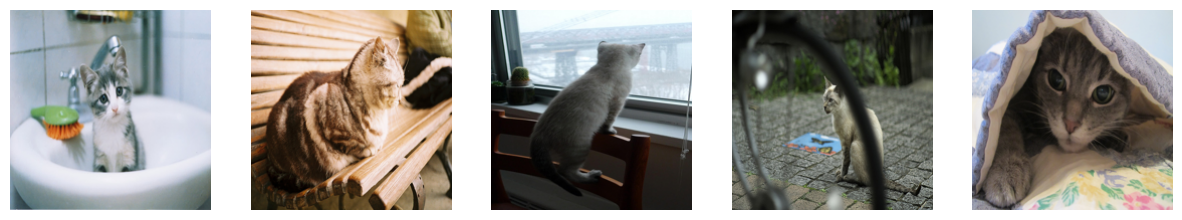

In [ ]:
search_results = brute_force_search(query_embedding, image_embeddings)
print(f"Query: {text}")
print("Search results:")
search_images = []
for search_result in search_results:
    idx, score = search_result['index'], search_result['score']
    row = mscoco_2014_test[idx]
    captions, image = row['caption'], row['image']
    print(f"{idx:5d}: {score:.5f} - {captions[0]}")
    image = image.resize((200, 200))
    search_images.append(image)
plot_image(search_images)

## FAISS

In [ ]:
import faiss

In [ ]:
dimension = image_embeddings.shape[1]
dimension

512

In [ ]:
image_embeddings = image_embeddings.cpu().numpy()

In [ ]:
def display_faiss_search_result(distances, search_indexs):
    search_images = []
    for distance, idx in zip(distances, search_indexs):
        idx = int(idx)
        row = mscoco_2014_test[idx]
        captions, image = row['caption'], row['image']
        print(f"{idx:5d}: {distance:.5f} - {captions[0]}")
        image = image.resize((200, 200))
        search_images.append(image)
    plot_image(search_images)

### IndexFlatL2

In [ ]:
flat_l2_index = faiss.IndexFlatL2(dimension)
flat_l2_index.is_trained

True

In [ ]:
flat_l2_index.add(image_embeddings)
flat_l2_index.ntotal

5000

In [ ]:
text = "cutie cat"
query_embedding = clip_embedder.encode([text], convert_to_tensor=True).cpu().numpy()

top_k = 5
distances, search_indexs = flat_l2_index.search(query_embedding, top_k)
print(distances, search_indexs)

[[149.82272 150.13351 151.22241 151.50583 152.94676]] [[2271 1404 2653 3578 2721]]


 2271: 149.82272 - A yellow and white cat sitting next to a book on a bed.
 1404: 150.13351 - An older man with a bow tie happily poses for a picture.
 2653: 151.22241 - A train coming down the tracks in a city. 
 3578: 151.50583 - The sign is in clear view by the traffic lights. 
 2721: 152.94676 - A remote controller made by Sony with a disclaimer on it.


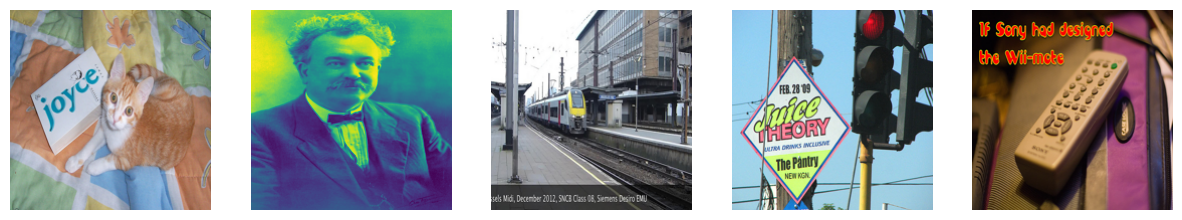

In [ ]:
display_faiss_search_result(distances[0], search_indexs[0])

### IndexFlatIP

In [ ]:
flat_ip_index = faiss.IndexFlatIP(dimension)
flat_ip_index.is_trained

True

In [ ]:
flat_ip_index.add(image_embeddings)
flat_ip_index.ntotal

5000

In [ ]:
text = "cutie cat"
query_embedding = clip_embedder.encode([text], convert_to_tensor=True)

top_k = 5
distances, search_indexs = flat_ip_index.search(query_embedding.cpu().numpy(), top_k)
print(distances, search_indexs)

[[32.531975 31.051584 31.00963  30.62529  30.598194]] [[2534 1740 2382 1399 3259]]


 2534: 32.53197 - a blurry picture of a cat and a window
 1740: 31.05158 - A gray and white kitten sitting in a bathroom sink.
 2382: 31.00963 - A cat sitting on a wooden bench outside.
 1399: 30.62529 - A furry cat sits on a blue chair. 
 3259: 30.59819 - A brown and white cat lying on a bed


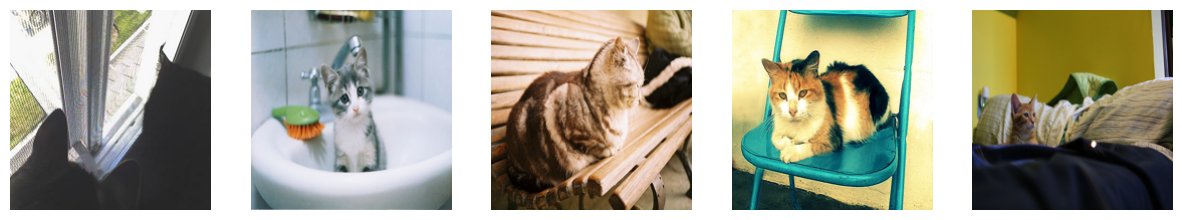

In [ ]:
display_faiss_search_result(distances[0], search_indexs[0])

### Preformance test

In [ ]:
captions = mscoco_2014_test['caption']
captions = [caption[0] for caption in captions]

In [ ]:
text_1k = captions[:1000]
query_embedding_1k = clip_embedder.encode(text_1k, convert_to_tensor=True).cpu().numpy()

In [ ]:
text_3k = captions[:3000]
query_embedding_3k = clip_embedder.encode(text_3k, convert_to_tensor=True).cpu().numpy()

In [ ]:
text_5k = captions[:5000]
query_embedding_5k = clip_embedder.encode(text_5k, convert_to_tensor=True).cpu().numpy()

In [ ]:
%%timeit
top_k = 5
_, _ = flat_ip_index.search(query_embedding_1k, top_k)

80.4 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%time
top_k = 5
_, _ = flat_ip_index.search(query_embedding_3k, top_k)

CPU times: user 242 ms, sys: 1.82 ms, total: 244 ms
Wall time: 245 ms


In [ ]:
%%timeit
top_k = 5
_, _ = flat_ip_index.search(query_embedding_5k, top_k)

447 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### IndexIVFFlat

In [ ]:
nlist = 50
quantizer = faiss.IndexFlatIP(dimension)
ivf_flat_index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
ivf_flat_index.is_trained

False

In [ ]:
ivf_flat_index.train(image_embeddings)
ivf_flat_index.is_trained

True

In [ ]:
ivf_flat_index.add(image_embeddings)
ivf_flat_index.ntotal

5000

In [ ]:
text = "cutie cat"
query_embedding = clip_embedder.encode([text], convert_to_tensor=True).cpu().numpy()

top_k = 5
distances, search_indexs = ivf_flat_index.search(query_embedding, top_k)
print(distances, search_indexs)

[[149.82272 155.7529  156.50542 157.05162 159.0044 ]] [[2271 1740 3968 4753 1057]]


 2271: 149.82272 - A yellow and white cat sitting next to a book on a bed.
 1740: 155.75290 - A gray and white kitten sitting in a bathroom sink.
 3968: 156.50542 - A very fluffy, calico-colored cat sits on the toilet seat. 
 4753: 157.05162 - A cat sitting in the middle of eight pairs of shoes.
 1057: 159.00439 - A cat sitting on top of a backpack on the ground.


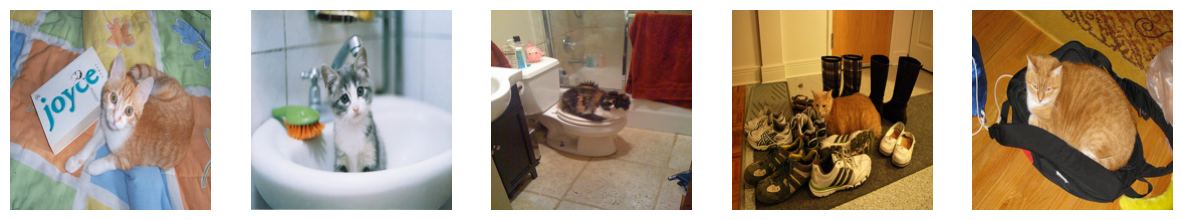

In [ ]:
display_faiss_search_result(distances[0], search_indexs[0])

In [ ]:
%%timeit

top_k = 5
_, _ = ivf_flat_index.search(query_embedding_1k, top_k)

26 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit

top_k = 5
_, _ = ivf_flat_index.search(query_embedding_3k, top_k)

63.4 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit

top_k = 5
_, _ = ivf_flat_index.search(query_embedding_5k, top_k)

114 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
ivf_flat_index.nprobe = 5

In [ ]:
%%timeit
top_k = 5
_, _ = ivf_flat_index.search(query_embedding_1k, top_k)

81.4 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### IndexIVFPQ

In [ ]:
nlist = 50
m = 4     # number of centroid IDs in final compressed vectors
bits = 4  # number of bits in each centroid

quantizer = faiss.IndexFlatIP(dimension)
ivf_pq_index = faiss.IndexIVFPQ(quantizer, dimension, nlist, m, bits)
ivf_pq_index.is_trained

False

In [ ]:
ivf_pq_index.train(image_embeddings)
ivf_pq_index.is_trained

True

In [ ]:
ivf_pq_index.add(image_embeddings)
ivf_pq_index.ntotal

5000

In [ ]:
text = "cutie cat"
query_embedding = clip_embedder.encode([text], convert_to_tensor=True).cpu().numpy()

top_k = 5
distances, search_indexs = ivf_pq_index.search(query_embedding, top_k)
print(distances, search_indexs)

[[118.07216 119.64289 119.65408 120.10424 120.59342]] [[2174 3738 4572 2271 2623]]


 2174: 118.07216 - A black cat rubbing up against a bottle of wine.
 3738: 119.64289 - A cat is on a table with a cloth on it.
 4572: 119.65408 - The small stuffed bear is propped into the car dashboard.
 2271: 120.10424 - A yellow and white cat sitting next to a book on a bed.
 2623: 120.59342 - A doll sitting at a table with fake food. 


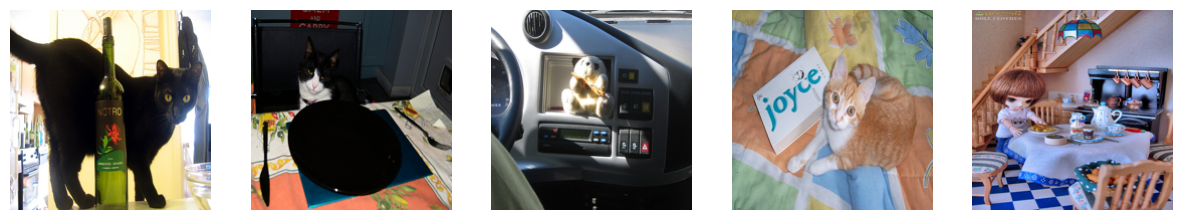

In [ ]:
display_faiss_search_result(distances[0], search_indexs[0])

In [ ]:
%%timeit
top_k = 5
_, _ = ivf_pq_index.search(query_embedding_1k, top_k)

9.99 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
top_k = 5
_, _ = ivf_pq_index.search(query_embedding_3k, top_k)

22.7 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
top_k = 5
_, _ = ivf_pq_index.search(query_embedding_5k, top_k)

38.6 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Further reading

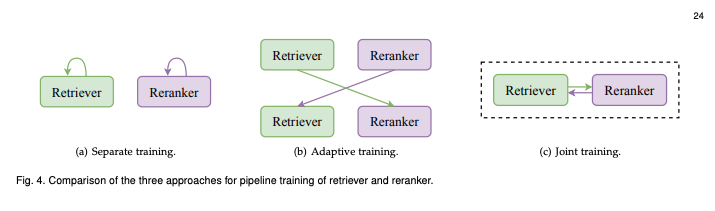

Zhao, W., Liu, J., Ren, R., & Wen, J.-R. (n.d.). Dense Text Retrieval based on Pretrained Language Models: A Survey. Retrieved from https://arxiv.org/pdf/2211.14876.pdf